In [192]:
import numpy as np
import glob
import imageio
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import math
import random

%matplotlib inline

# os.chdir('DATA_LableMaker')

# Finding empty tiles / labels

In [175]:
cur_dir = os.getcwd() # current dir path

data_dir = os.path.join(cur_dir, 'data1')
list_dir = os.listdir(data_dir)

In [8]:
# finding empty tiles +
# list of all folders in the data folder
folderNames = []
filesToBeDeleted = []

for dirPath in glob.glob("data1/*/"):
    folderNames.append(dirPath.split('/')[1])

folderNamesToDelete=[]
for f in folderNames:
    counter=0
    emptyImgCounter=0
    for image_path in glob.glob('data1/{}/tiles/*.jpg'.format(f)):
        try:
            temp=imageio.imread(image_path)
            if(temp.sum()==0):
                filesToBeDeleted.append(image_path)
        except:
            filesToBeDeleted.append(image_path)
            

In [176]:
# filesToBeDeleted: list of all empty LABELS in the data1 folder
# movel_empty_tile_and_label_to_DELETE: if active, move filesToBeDeleted (labels and tiles) to data1/DELETE

folderNames = os.listdir(data_dir)
filesToBeDeleted = []

try:
    os.makedirs(data_dir+'/DELETE')
except:
    pass

def movel_empty_tile_and_label_to_DELETE(image_path, f):
    # paths to label and corresponding tile to move
    label_to_move = os.path.join(cur_dir, image_path)
    tile_to_move = os.path.join(cur_dir, image_path.replace('labels', 'tiles').replace('png', 'jpg'))
    # move selected label and tile to data1/DELETE/<zoom_projectID>
    try:
        os.makedirs(data_dir+'/DELETE/'+f)
    except:
        pass
    dest = os.path.join(data_dir, 'DELETE/'+f)
    shutil.move(label_to_move, dest)
    shutil.move(tile_to_move, dest)
    
    

for f in folderNames:
    for image_path in glob.glob('data1/{}/labels/*.png'.format(f)):
        try:
            temp=imageio.imread(image_path)
            if(temp.sum()==0):
                filesToBeDeleted.append(image_path)
                movel_empty_tile_and_label_to_DELETE(image_path, f)
        except:
            filesToBeDeleted.append(image_path)
            movel_empty_tile_and_label_to_DELETE(image_path, f)
            

# Counting images

In [292]:
# count all tiles in the folder: folder/<name>/tiles/<image_name>.jpg
def count_tiles(folder):
    folderNames = []
    folderTileCounts = []

    for dirPath in glob.glob(folder+"/*/"):
        folderNames.append(dirPath.split('/')[-2])

    for f in folderNames:
        projectID, projectZoom = int(f.split('_')[-1]), int(f.split('_')[0])
        numImages=0
        for image_path in glob.glob(folder+'/{}/tiles/*.jpg'.format(f)):
            numImages += 1
        folderTileCounts.append([projectID, projectZoom, numImages])

    return np.array(folderTileCounts)

In [290]:
folderTileCounts = count_tiles('data1')

In [190]:
# group by project ID and sort by number of tiles
df = pd.DataFrame(tileCountsArr)
grouped = df.groupby([0]).sum()
grouped_sorted = grouped.sort_values(by=2)

df_17 = df[df[1] == 17]
df_18 = df[df[1] == 18]

In [316]:
# total number of tiles
df.sum()[2]

36595

In [333]:
# IDs of all projects we use
np.sort(df[0].unique())

array([3505, 3523, 3649, 3685, 3697, 3991, 3992, 3994, 3995, 4048, 4052,
       4057, 4058, 4195, 5011, 5021, 5027, 5303, 5370, 5397, 5405])

In [318]:
df_17_sorted = df_17.sort_values(by=2)
df_18_sorted = df_18.sort_values(by=2)

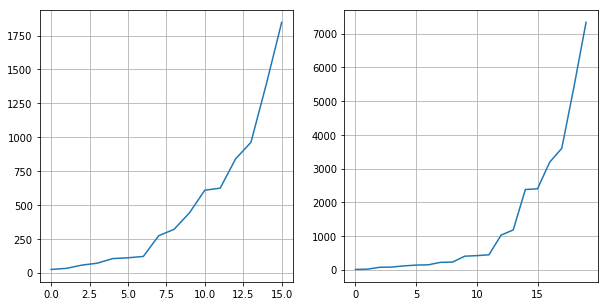

In [319]:
# distribution of number of tiles in different projects
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(list(df_17_sorted[2]))
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(list(df_18_sorted[2]))
plt.grid()
plt.show()

# Train/validation/test split

In [243]:
# first: selecting entire projects

df_val = grouped_sorted.iloc[:-5][::3]
ids_val = list(df_val.index)

df_test = grouped_sorted.iloc[:-5][1::3]
ids_test = list(df_test.index)

exclude = grouped_sorted.index.isin(ids_val + ids_test)

df_train = grouped_sorted[~exclude]
ids_train = list(df_train.index)

assert len(ids_val) + len(ids_test) + len(ids_train) == grouped_sorted.index.shape[0], 'Bad split'

total = grouped_sorted.sum()[2]
print('Train:', round(df_train.sum()[2] / total * 100, 2), '%')
print('Val:', round(df_val.sum()[2] / total * 100, 2), '%')
print('Test:', round(df_test.sum()[2] / total * 100, 2), '%')


Train: 82.3 %
Val: 11.59 %
Test: 6.12 %


In [251]:
# moving them to corresponding folders: Train, Validation, Test

cur_dir = os.getcwd() # current dir path

data_dir = os.path.join(cur_dir, 'data1')
list_dir = os.listdir(data_dir)

try:
    os.makedirs(cur_dir+'/data1_split')
    os.makedirs(cur_dir+'/data1_split/Train')
    os.makedirs(cur_dir+'/data1_split/Validation')
    os.makedirs(cur_dir+'/data1_split/Test')
    os.makedirs(cur_dir+'/data1_split/Validation_Randomized')
    os.makedirs(cur_dir+'/data1_split/Test_Randomized')
except:
    pass

dest_train = os.path.join(cur_dir, 'data1_split/Train') 
dest_val = os.path.join(cur_dir, 'data1_split/Validation') 
dest_test = os.path.join(cur_dir, 'data1_split/Test') 

for sub_dir in list_dir:
    ID = int(sub_dir.split('_')[-1])
    if ID in ids_train:
        dir_to_move = os.path.join(data_dir, sub_dir)
        shutil.move(dir_to_move, dest_train)
    elif ID in ids_val:
        dir_to_move = os.path.join(data_dir, sub_dir)
        shutil.move(dir_to_move, dest_val)
    elif ID in ids_test:
        dir_to_move = os.path.join(data_dir, sub_dir)
        shutil.move(dir_to_move, dest_test)
        

In [254]:
def generate_random_samples(source, destination):
    for project in os.listdir(source):
        dest_project = source+'/'+project

        labels = os.listdir(dest_project+'/labels')
        n = math.ceil(len(labels) / 10)
        random_labels = random.sample(labels, n)
        try:
            os.makedirs(destination+'/'+project+'/tiles')
            os.makedirs(destination+'/'+project+'/labels')
        except:
            pass
        for label in random_labels:
            shutil.move(dest_project+'/labels'+'/'+label, destination+'/'+project+'/labels')
            shutil.move(dest_project+'/tiles'+'/'+label.replace(".png",".jpg"), destination+'/'+project+'/tiles')

In [255]:
dest_val_random = os.path.join(cur_dir, 'data1_split/Validation_Randomized') 
dest_test_random = os.path.join(cur_dir, 'data1_split/Test_Randomized')

try:
    os.makedirs(dest_val_random+'/labels')
    os.makedirs(dest_val_random+'/tiles')

    os.makedirs(dest_test_random+'/labels')
    os.makedirs(dest_test_random+'/tiles')
except:
    pass

generate_random_samples(dest_train,dest_test_random)
generate_random_samples(dest_train,dest_val_random)

In [312]:
# count tiles
n = [count_tiles('data1_split/Train'),
    count_tiles('data1_split/Validation'),
    count_tiles('data1_split/Test'),
    count_tiles('data1_split/Validation_Randomized'),
    count_tiles('data1_split/Test_Randomized')
    ]

n = [i[:,-1].sum() for i in n]
print('Number of all tiles:',sum(n))
print('Train: %i%%' % round(n[0] / sum(n) * 100), '(%i)' % n[0])
print('Validation: %i%%' % round((n[1] + n[3]) / sum(n) * 100), '(%i)' % (n[1] + n[3]))
print('Test: %i%%' % round((n[2] + n[4]) / sum(n) * 100), '(%i)' % (n[2] + n[4]))

Number of all tiles: 36595
Train: 67% (24380)
Validation: 19% (6959)
Test: 14% (5256)


In [306]:
# total number of tiles (check)
sum([i[:,-1].sum() for i in n])

36595

# Distribution of labels

In [ ]:
folderNames = []
filesToBeDeleted = []

for dirPath in glob.glob("data1/*/"):
    folderNames.append(dirPath.split('/')[1])

folderNamesToDelete=[]
for f in folderNames:
    counter=0
    emptyImgCounter=0
    for image_path in glob.glob('data1/{}/labels/*.png'.format(f)):
        try:
            temp=imageio.imread(image_path)
            if(temp.sum()==0):
                filesToBeDeleted.append(image_path)
        except:
            filesToBeDeleted.append(image_path)
           

In [356]:
import numpy as np


image_path = 'data1/17_3697/labels/77744-68798-17.png'
img = np.array(imageio.imread(image_path))

folderNames = []


for dirPath in glob.glob("data1/*/"):
    folderNames.append(dirPath.split('/')[1])

    
background_pix = 0
highway_pix = 0
building_pix = 0

for f in folderNames:
    for image_path in glob.glob('data1/{}/labels/*.png'.format(f)):
        try:
            img = np.array(imageio.imread(image_path))
            for x in img.reshape(-1,3):
                pix_sum = np.sum([x[0],x[1],x[2]])
                if(pix_sum == 0):
                    background_pix += 1
                if(pix_sum == 425):
                    highway_pix += 1
                if(pix_sum == 187):
                    building_pix += 1
        except:
            pass
        
print(background_pix, highway_pix, building_pix)

2086138961 17139895 295011064
